In [5]:
import sys
sys.path.append('../')

In [35]:
import matplotlib.pyplot as plt
import torch

In [27]:
from data.eval_dataset import Dataset_3DPW
from models.smpl import get_smpl_model
from data.display_utils import display_model

In [7]:
dataset = Dataset_3DPW()

In [55]:
len(dataset)

35515

In [56]:
sample1 = dataset[100]
sample2 = dataset[35000]

In [57]:
(sample1['shape']== sample2['shape']).all()

tensor(False)

In [58]:
smpl_male = get_smpl_model(gender='male')
res_gt1 = smpl_male(global_orient=sample1['pose'].unsqueeze(0)[:,:3],body_pose=sample1['pose'].unsqueeze(0)[:,3:],betas=sample1['shape'].unsqueeze(0),pose2rot=True)
res_gt2 = smpl_male(global_orient=sample2['pose'].unsqueeze(0)[:,:3],body_pose=sample2['pose'].unsqueeze(0)[:,3:],betas=sample2['shape'].unsqueeze(0),pose2rot=True)

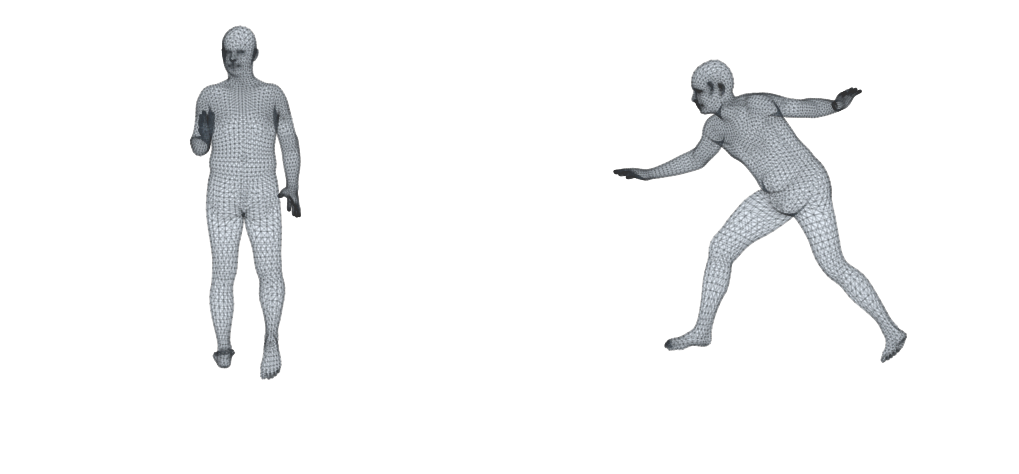

In [59]:
fig= plt.figure(figsize=(10,5))
ax1 = fig.add_axes(121,projection='3d')
ax2 = fig.add_axes(122,projection='3d')

ax1 = display_model(
            {'verts': res_gt1.vertices.cpu().detach(),
             'joints': res_gt1.joints[0,:24,:].cpu().detach()},
            model_faces=smpl_male.faces.astype(int),
            with_joints=False,
            kintree_table=smpl_male.parents,
            savepath=None,
            show=False,
            ax=ax1)
ax1.view_init(elev=-90,azim=-90)
ax1.set_axis_off()

ax2 = display_model(
            {'verts': res_gt2.vertices.cpu().detach(),
             'joints': res_gt2.joints[0,:24,:].cpu().detach()},
            model_faces=smpl_male.faces.astype(int),
            with_joints=False,
            kintree_table=smpl_male.parents,
            savepath=None,
            show=False,
            ax=ax2)
ax2.view_init(elev=-90,azim=-90)
ax2.set_axis_off()


In [60]:
smpl_joints = res_gt1.joints[:,1:24,:] #has shape of [b,23,3], take all except the pelvis
parents = smpl_male.parents[1:].unsqueeze(-1).unsqueeze(0)# has shape of [1,23,1]
#parents_joints = torch.take_along_dim(res_gt1.joints,parents,dim=1)
diff = smpl_joints - torch.take_along_dim(res_gt1.joints,parents,dim=1)
joints_feat1 = torch.linalg.norm(diff,dim=-1)

smpl_joints = res_gt2.joints[:,1:24,:] #has shape of [b,23,3], take all except the pelvis
parents = smpl_male.parents[1:].unsqueeze(-1).unsqueeze(0)# has shape of [1,23,1]
#parents_joints = torch.take_along_dim(res_gt1.joints,parents,dim=1)
diff = smpl_joints - torch.take_along_dim(res_gt2.joints,parents,dim=1)
joints_feat2 = torch.linalg.norm(diff,dim=-1)


In [61]:
joints_feat1.shape,joints_feat2.shape

(torch.Size([1, 23]), torch.Size([1, 23]))

In [62]:
joints_feat1,joints_feat2

(tensor([[0.1007, 0.1084, 0.1279, 0.3843, 0.3805, 0.1367, 0.4189, 0.4119, 0.0542,
          0.1381, 0.1441, 0.2041, 0.1288, 0.1345, 0.0986, 0.1229, 0.1124, 0.2442,
          0.2462, 0.2532, 0.2563, 0.0847, 0.0852]],
        grad_fn=<LinalgVectorNormBackward0>),
 tensor([[0.1032, 0.1105, 0.1296, 0.4101, 0.4072, 0.1374, 0.4500, 0.4433, 0.0542,
          0.1438, 0.1500, 0.2084, 0.1340, 0.1395, 0.1044, 0.1309, 0.1215, 0.2621,
          0.2667, 0.2699, 0.2737, 0.0876, 0.0882]],
        grad_fn=<LinalgVectorNormBackward0>))